# Hourly Forecasting Carbon Intensity using SARIMA #

## Importing modules ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import time
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'

In [ ]:
start_time = time.time()
df = pd.read_csv('../../data/df_fuel_ckan.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Filter for history and the test year (2025)
df_filtered = df[df['DATETIME'].dt.year < 2025].copy().set_index('DATETIME')
df_2025 = df[df['DATETIME'].dt.year == 2025].copy().set_index('DATETIME')

# Use 30 days for balance between speed and accuracy
data_train = df_filtered['CARBON_INTENSITY'].resample('h').mean().interpolate().tail(24 * 30)
actual_2025 = df_2025['CARBON_INTENSITY'].resample('h').mean().interpolate()

def create_time_features(index):
    df_feat = pd.DataFrame(index=index)
    df_feat['hour'] = index.hour / 23.0  # Normalize to [0,1]
    df_feat['day_of_week'] = index.dayofweek / 6.0
    return df_feat.values  # Only 2 features for speed

X_train = create_time_features(data_train.index)
X_future = create_time_features(actual_2025.index)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(data_train.values.reshape(-1, 1)).flatten()

In [3]:
stepwise_model = pm.auto_arima(
    y=y_train_scaled,
    X=X_train,
    seasonal=True,
    m=24,
    start_p=1, start_q=1,
    start_P=0, start_Q=0,
    max_p=3, max_q=2,
    max_P=1, max_Q=1,
    d=None, D=None,
    max_d=2, max_D=1,
    test='adf',
    seasonal_test='ocsb',
    stepwise=False,
    n_jobs=-1,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='aic',
    trace=True,
    with_intercept=False,
    maxiter=50,
    method='lbfgs'
)


Best model:  ARIMA(1,1,1)(1,0,0)[24]          
Total fit time: 24.914 seconds


In [4]:
forecast_scaled = stepwise_model.predict(
    n_periods=len(actual_2025),
    X=X_future
)

# Inverse transform to original scale
forecast_values = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
forecast_series = pd.Series(forecast_values, index=actual_2025.index)


Performance Metrics:
MAE: 64.43 gCO2/kWh
RMSE: 83.05 gCO2/kWh


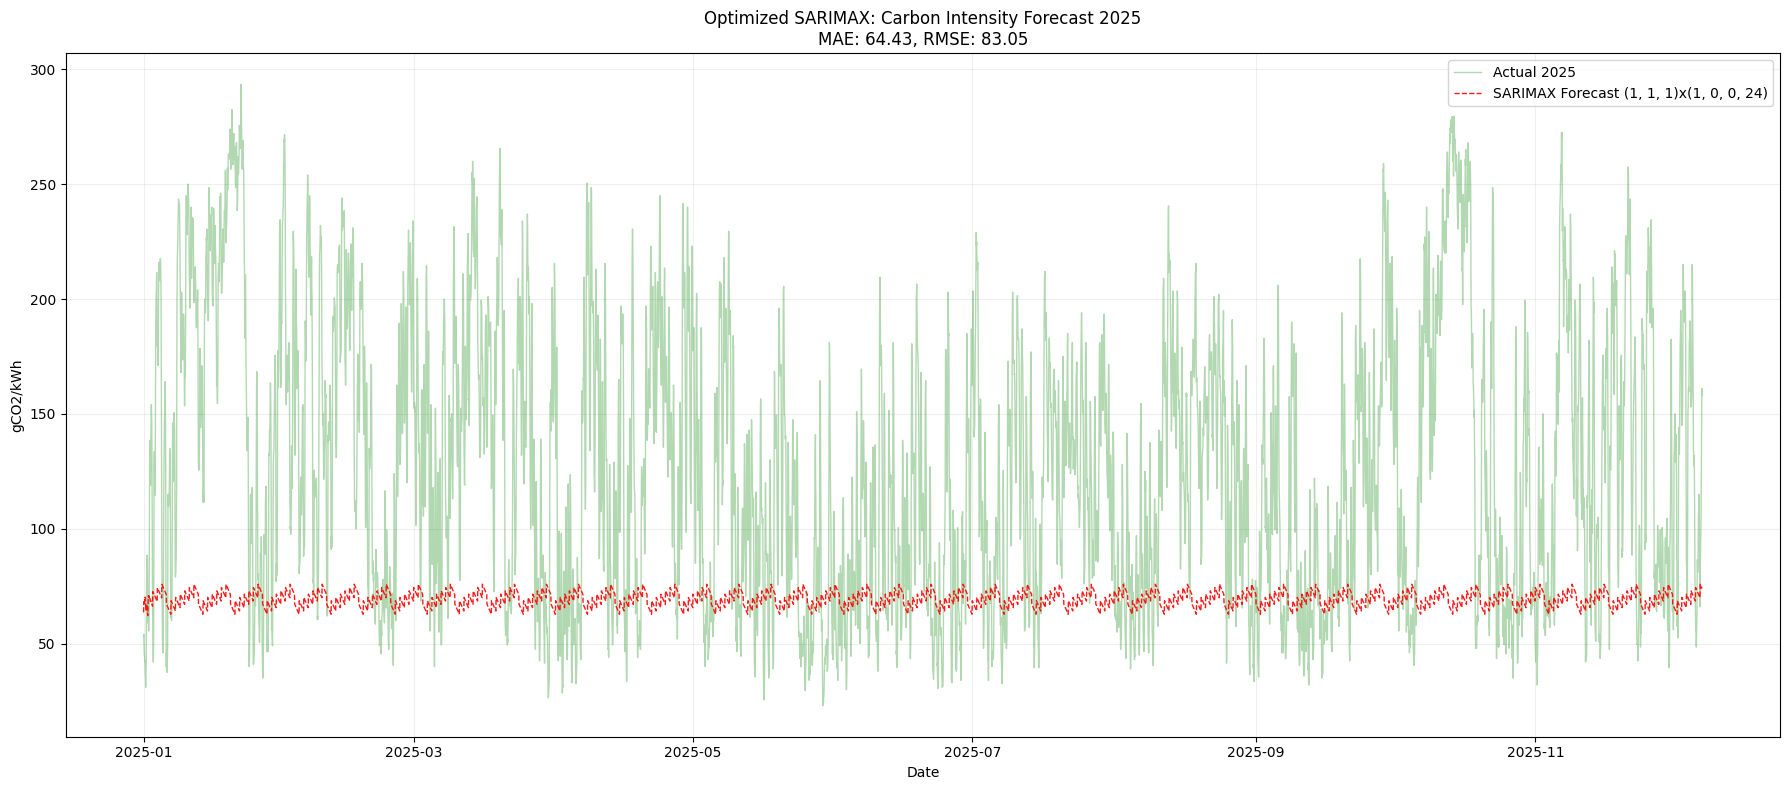


Execution Time: 26.32 seconds


In [5]:
mae = mean_absolute_error(actual_2025, forecast_series)
rmse = np.sqrt(mean_squared_error(actual_2025, forecast_series))

print(f"\nPerformance Metrics:")
print(f"MAE: {mae:.2f} gCO2/kWh")
print(f"RMSE: {rmse:.2f} gCO2/kWh")

plt.figure(figsize=(18, 8))

# Plot actuals
plt.plot(actual_2025.index, actual_2025, label='Actual 2025', 
         color='green', alpha=0.3, linewidth=1)

# Plot forecast
plt.plot(forecast_series.index, forecast_series, 
         label=f'SARIMAX Forecast {stepwise_model.order}x{stepwise_model.seasonal_order}', 
         color='red', linestyle='--', alpha=0.9, linewidth=1)

plt.title(f'Optimized SARIMAX: Carbon Intensity Forecast 2025\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Date')
plt.ylabel('gCO2/kWh')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()
execution_time = time.time() - start_time
print(f"\nExecution Time: {execution_time:.2f} seconds")    